In [1]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells
import os
import tensorflow as tf
import numpy as np
import sys
DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/home/cadu/notebook/CNN-Human-Activity
cnn.ipynb  data
/home/cadu/notebook/CNN-Human-Activity/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/home/cadu/notebook/CNN-Human-Activity/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip
/home/cadu/notebook/CNN-Human-Activity
cnn.ipynb  data

Dataset is now located at: data/UCI HAR Dataset/


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


In [3]:
TRAIN = "train/"
TEST = "test/"

# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths) 
print('This is X_train',X_train.shape,len(X_train))   # 7352 128 9
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1            #return y_-1 

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
print('This is y_train.shape|len:',y_train.shape,len(y_train))   # 7352 1
y_test = load_y(y_test_path)

n_values = int(np.max(y_train)) + 1
print('This is n_values',n_values)

This is X_train (7352, 128, 9) 7352
This is y_train.shape|len: (7352, 1) 7352
This is n_values 6


In [4]:
##
def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

"""
x_image = tf.reshape(X_train, [-1, 128, 9, 1])
print(X_train.shape,x_image.shape)
Weight_var=weight_variable([5,5,1,32])
conv1=conv2d(x_image,Weight_var)
hpool1=max_pool_2x2(conv1)
print(hpool1.shape)
"""

'\nx_image = tf.reshape(X_train, [-1, 128, 9, 1])\nprint(X_train.shape,x_image.shape)\nWeight_var=weight_variable([5,5,1,32])\nconv1=conv2d(x_image,Weight_var)\nhpool1=max_pool_2x2(conv1)\nprint(hpool1.shape)\n'

In [5]:
# CNN
def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.

  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.

  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 9, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)
    print(h_pool2.shape)
  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([32 * 3 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 32*3*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, 6])
    b_fc2 = bias_variable([6])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob
def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape) #_X  7352 128 9
    shape[0] = batch_size      # 1500 128 9
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train) # step=1 
        batch_s[i] = _train[index] 

    return batch_s
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    #n_values = 6
    #print('The n_values is:',n_values)
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [34]:
def main():
  # Import data
  #mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

  # Create the model
  x = tf.placeholder(tf.float32, [None, 128,9])

  # Define loss and optimizer
  y_ = tf.placeholder(tf.float32, [None, 6])

  # Build the graph for the deep net
  y_conv, keep_prob = deepnn(x)

  with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
  cross_entropy = tf.reduce_mean(cross_entropy)

  with tf.name_scope('adam_optimizer'):
    #train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  #graph_location = tempfile.mkdtemp()
  graph_location="/tmp/tensorboard"
  print('Saving graph to: %s' % graph_location)
  train_writer = tf.summary.FileWriter(graph_location)
  train_writer.add_graph(tf.get_default_graph())
  
    
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
      x_batch = extract_batch_size(X_train, i, 200)
      y_batch = one_hot(extract_batch_size(y_train, i, 200))
      #print(y_batch.shape,y_batch)
      if i % 50 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: x_batch, y_: y_batch, keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
        loss=sess.run(cross_entropy,feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
        train_losses.append(loss)
        train_accuracies.append(train_accuracy)
      train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
    #print(train_losses)
    #print(train_accuracies)
      

    #print('test accuracy %g' % accuracy.eval(feed_dict={
        #x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [35]:
#if __name__=='__main__':
train_losses=[]
train_accuracies=[]
main()
print(train_losses)
print(train_accuracies)


(?, 32, 3, 64)
Saving graph to: /tmp/tensorboard
step 0, training accuracy 0.16
step 50, training accuracy 0.685
step 100, training accuracy 0.78
step 150, training accuracy 0.935
step 200, training accuracy 0.48
step 250, training accuracy 0.99
step 300, training accuracy 0.93
step 350, training accuracy 0.95
step 400, training accuracy 0.855
step 450, training accuracy 0.91
step 500, training accuracy 1
step 550, training accuracy 0.9
step 600, training accuracy 0.9
step 650, training accuracy 0.965
step 700, training accuracy 0.995
step 750, training accuracy 0.975
step 800, training accuracy 0.99
step 850, training accuracy 0.885
step 900, training accuracy 0.925
step 950, training accuracy 1
[16.019777, 2.0959218, 0.97522551, 0.43179435, 1.4268738, 0.25743094, 0.28261167, 0.33971447, 0.6770485, 0.21892692, 0.12617205, 0.23944725, 0.27456897, 0.19578096, 0.082264096, 0.2115134, 0.12611499, 0.24646178, 0.13705854, 0.052654058]
[0.16, 0.685, 0.77999997, 0.935, 0.47999999, 0.99000001,

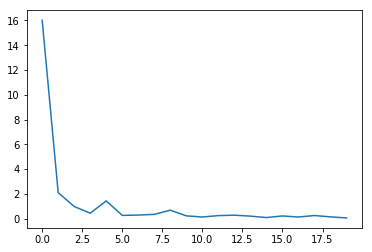

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses)
plt.show()


In [16]:
print(train_losses)

NameError: name 'train_losses' is not defined